# Nonlinear recharge models
*R.A. Collenteur, University of Graz*

This notebook explains the use of the `RechargeModel` stress model to simulate the combined effect of precipitation and potential evaporation on the groundwater levels. For the computation of the groundwater recharge, three recharge models are currently available:

- `Linear` ([Berendrecht et al., 2003](#References); [von Asmuth et al., 2008](#References))
- `Berendrecht` ([Berendrecht et al., 2006](#References))
- `FlexModel` ([Collenteur et al., 2021](#References))

The first model is a simple linear function of precipitation and potential evaporation while the latter two are simulate a nonlinear response of recharge to precipitation using a soil-water balance concepts. Detailed descriptions of these models can be found in articles listed in the [References](#References) at the end of this notebook.

<div class="alert alert-info">
    
<b>Tip</b> 
    
To run this notebook and the related non-linear recharge models, it is strongly recommended to install Numba (http://numba.pydata.org). This Just-In-Time (JIT) compiler compiles the computationally intensive part of the recharge calculation, making the non-linear model as fast as the Linear recharge model.
    
</div>


In [1]:
import pandas as pd
import pastas as ps
import matplotlib.pyplot as plt

ps.show_versions(numba=True)
ps.set_log_level("INFO")

Python version: 3.8.2 (default, Mar 25 2020, 11:22:43) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy version: 1.20.2
Scipy version: 1.6.2
Pandas version: 1.1.5
Pastas version: 0.18.0b
Matplotlib version: 3.3.4
numba version: 0.51.2


## Read Input data
Input data handling is similar to other stressmodels. The only thing that is necessary to check is that the precipitation and evaporation are provided in mm/day. This is necessary because the parameters for the nonlinear recharge models are defined in mm for the length unit and days for the time unit. It is possible to use other units, but this would require manually setting the initial values and parameter boundaries for the recharge models.

INFO: Inferred frequency for time series EV24 260: freq=D
INFO: Inferred frequency for time series RH 260: freq=D


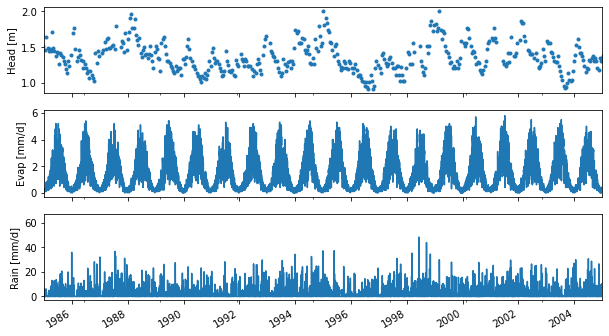

In [2]:
head = pd.read_csv("../data/B32C0639001.csv",  parse_dates=['date'], 
                   index_col='date', squeeze=True) 

# Make this millimeters per day
evap = ps.read_knmi("../data/etmgeg_260.txt", variables="EV24").series * 1e3
rain = ps.read_knmi("../data/etmgeg_260.txt", variables="RH").series * 1e3

fig, axes = plt.subplots(3,1, figsize=(10,6), sharex=True)
head.plot(ax=axes[0], x_compat=True, linestyle=" ", marker=".")
evap.plot(ax=axes[1], x_compat=True)
rain.plot(ax=axes[2], x_compat=True)
axes[0].set_ylabel("Head [m]")
axes[1].set_ylabel("Evap [mm/d]")
axes[2].set_ylabel("Rain [mm/d]")

plt.xlim("1985", "2005");

## Make a basic model
The normal workflow may be used to create and calibrate the model.
1. Create a Pastas `Model` instance
2. Choose a recharge model. All recharge models can be accessed through the recharge subpackage (`ps.rch`).
3. Create a `RechargeModel` object and add it to the model
4. Solve and visualize the model



INFO: Cannot determine frequency of series head: freq=None. The time series is irregular.
INFO: Inferred frequency for time series RH 260: freq=D
INFO: Inferred frequency for time series EV24 260: freq=D


Fit report head                      Fit Statistics
nfev    31                     EVP           88.21
nobs    351                    R2             0.88
noise   1                      RMSE           0.07
tmin    1990-01-01 00:00:00    AIC        -2067.59
tmax    2005-10-14 00:00:00    BIC        -2036.70
freq    D                      Obj            0.46
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (8 optimized)
                optimal   stderr     initial   vary
rch_A          0.413835   ±6.82%    0.721210   True
rch_n          0.664691   ±3.60%    1.000000   True
rch_a        306.743876  ±15.99%   10.000000   True
rch_srmax     63.726446   ±6.27%  250.000000   True
rch_lp         0.250000    ±nan%    0.250000  False
rch_ks        30.314573  ±11.24%  100.000000   True
rch_gamma      3.357982   ±8.33%    4.000000   True
rch_simax      2.000000    ±nan%    2.000000  False
rch_kv         1.000000    ±nan%    1.000000  

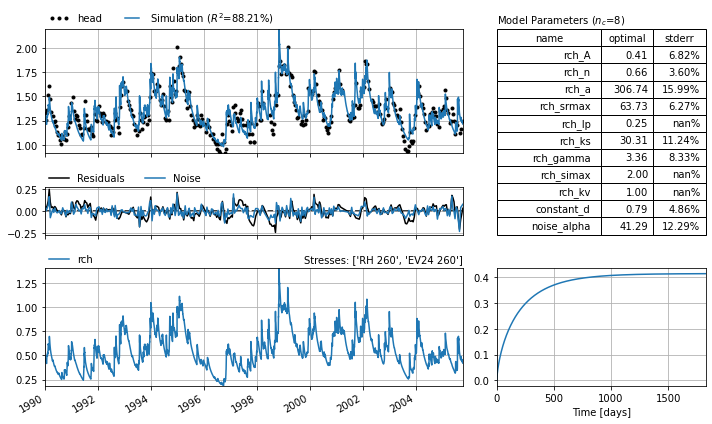

In [3]:
ml = ps.Model(head)

# Select a recharge model
rch = ps.rch.FlexModel()
#rch = ps.rch.Berendrecht()
#rch = ps.rch.Linear()

rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Gamma, name="rch")
ml.add_stressmodel(rm)

ml.solve(noise=True, tmin="1990", report="basic")
ml.plots.results(figsize=(10,6));

## Analyze the estimated recharge flux
After the parameter estimation we can take a look at the recharge flux computed by the model. The flux is easy to obtain using the `get_stress` method of the model object, which automatically provides the optimal parameter values that were just estimated. After this, we can for example look at the yearly recharge flux estimated by the Pastas model.

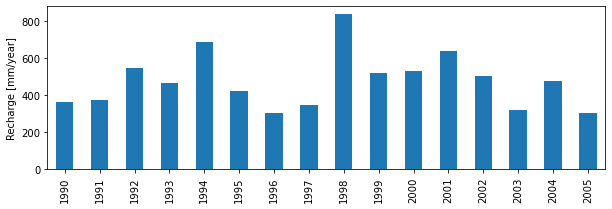

In [4]:
recharge = ml.get_stress("rch").resample("A").sum()
ax = recharge.plot.bar(figsize=(10,3))
ax.set_xticklabels(recharge.index.year)
plt.ylabel("Recharge [mm/year]");

## A few things to keep in mind:
Below are a few things to keep in mind while using the (nonlinear) recharge models.

- The use of an appropriate warmup period is necessary, so make sure the precipitation and evaporation are available some time (e.g., one year) before the calibration period.
- Make sure that the units of the precipitation fluxes are in mm/day and that the DatetimeIndex matches exactly.
- It may be possible to fix or vary certain parameters, dependent on the problem. Obtaining better initial parameters may be possible by solving without a noise model first (`ml.solve(noise=False)`) and then solve it again using a noise model.
- For relatively shallow groundwater levels, it may be better to use the `Exponential` response function as the the non-linear models already cause a delayed response.

## References
- Berendrecht, W. L., Heemink, A. W., van Geer, F. C., and Gehrels, J. C. (2003) [Decoupling of modeling and measuring interval in groundwater time series analysis based on response characteristics](https://doi.org/10.1016/S0022-1694(03)00075-1), Journal of Hydrology, 278, 1–16.
- Berendrecht, W. L., Heemink, A. W., van Geer, F. C., and Gehrels, J. C. (2006) [A non-linear state space approach to model groundwater fluctuations](https://www.sciencedirect.com/science/article/abs/pii/S0309170805002113), Advances in Water Resources, 29, 959–973.
- Collenteur, R., Bakker, M., Klammler, G., and Birk, S. (2021) [Estimation of groundwater recharge from groundwater levels using nonlinear transfer function noise models and comparison to lysimeter data](https://doi.org/10.5194/hess-2020-392), Hydrol. Earth Syst. Sci., 25, 2931–2949.
- Von Asmuth, J.R., Maas, K., Bakker, M. and Petersen, J. (2008) [Modeling Time Series of Ground Water Head Fluctuations Subjected to Multiple Stresses](https://doi.org/10.1111/j.1745-6584.2007.00382.x). Groundwater, 46: 30-40.

## Data Sources
In this notebook we analysed a head time series near the town of De Bilt in the Netherlands. Data is obtained from the following resources:
- The heads (`B32C0639001.csv`) are downloaded from https://www.dinoloket.nl/ 
- The precipitation and potential evaporation (`etmgeg_260.txt`) are downloaded from https://knmi.nl